# Project Introduction- "BITCOIN PRICE MOVEMENT BASED ON NEWS"
--------------------
This proejct is about predicting future Bitcoin prices based on the sentiment of news articles related to Bitcoin. The sentiment analysis will be performed using Natural Language Processing (NLP) techniques.

# 1. Setup and Libraries
--------------------
Importing libraries necessary for handling web requests, data manipulation, natural language processing, visualizations and machine learning.


In [140]:
import requests
import nltk
import re
from nltk.corpus import stopwords
from textblob import TextBlob
import ccxt
import pandas as pd
from datetime import datetime, timedelta
from datetime import timezone
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta, timezone


### Downloading NLTK stopwords
--------------------
Stop words are common words that are usually irrelevant to the analysis, like 'and', 'the', etc.

In [141]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. Data Collection
----------------
. Using New API to fetch articles related to Bitcoin.
. Here, we are fetching 100 articles using the News API key and Keyword 'Bitcoin' . The data is in the for of a list of tuples and each tuple contains the title, description, publication date, and URL of an article.

. Using try and except block to handle any errors that may occur during the API request.


In [142]:
def fetch_articles(api_key, keyword):
    try:
        url = f'https://newsapi.org/v2/everything?q={keyword}&apiKey={api_key}'
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            return [(article['title'], article['description'], article['publishedAt'], article['url']) for article in data['articles']]
        else:
            print("Failed to fetch data:", response.status_code)
    except Exception as e:
        print("An error occurred:", e)

api_key = 'b55ad14a15f94d22a5ccfe3f5d028246'
bitcoin_articles = fetch_articles(api_key, 'Bitcoin')


In [143]:
for (i, article) in enumerate(bitcoin_articles):
    print(article)
    if i >= 5:
        break

print(f'\nTotal Number of Articles we have: {len(bitcoin_articles)}')

('The First Bitcoin President? Tracing Trump’s Crypto Connections', 'Crypto execs funneled millions in donations to swing this election, and now their man is in charge. Here’s how Donald Trump’s “crypto cabinet” could shape the next four years.', '2025-01-16T11:00:00Z', 'https://www.wired.com/story/mapping-donald-trump-crypto-connections/')
('Policy Proposal for Trump’s Bitcoin Stockpile Leaks', 'The main argument seems to be "China."', '2025-01-16T21:05:53Z', 'https://gizmodo.com/policy-proposal-for-trumps-bitcoin-stockpile-leaks-2000551372')
("Judge Ends One Man's 11-Year Quest to Recover $765 Million in Bitcoin by Digging Up a Landfill", 'A UK judge ruled against James Howells, who has been trying to get a hard drive with private keys to a cryptocurrency fortune out of a landfill for over a decade.', '2025-01-13T20:25:06Z', 'https://www.wired.com/story/bitcoin-landfill-excavation-james-howells-judge-ruling/')
('Trump pardons Silk Road operator Ross Ulbricht', 'Pardoning Ulbricht, wh

# 3. Data Cleaning and Preprocessing
-------------------------------
Cleaning the text of the articles by removing HTML tags, punctuation, numbers, and converting all text to lowercase.

Also removing the stopwords from the text. as they are not useful for sentiment analysis.

## 3.1 Cleanign Articles

In [144]:
def clean_text(text):
    if text is None:
        return ""
    text = re.sub(r'<.*?>', '', text)  # Removing HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Removing punctuation
    text = re.sub(r'\d+', '', text)  # Removing numbers
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Removing stopwords
    return text


## 3.2 Processing Articles

In [145]:

def clean_article(article):
    title, description, published_at, url = article
    cleaned_title = clean_text(title)
    cleaned_description = clean_text(description)
    return (cleaned_title, cleaned_description, published_at, url)

clean_articles = [clean_article(article) for article in bitcoin_articles]

In [146]:
for (i, article) in enumerate(clean_articles):
    print(article)
    if i >= 5:
        break

print(f'\nTotal Number of Articles we have: {len(clean_articles)}')

('first bitcoin president tracing trumps crypto connections', 'crypto execs funneled millions donations swing election man charge heres donald trumps crypto cabinet could shape next four years', '2025-01-16T11:00:00Z', 'https://www.wired.com/story/mapping-donald-trump-crypto-connections/')
('policy proposal trumps bitcoin stockpile leaks', 'main argument seems china', '2025-01-16T21:05:53Z', 'https://gizmodo.com/policy-proposal-for-trumps-bitcoin-stockpile-leaks-2000551372')
('judge ends one mans year quest recover million bitcoin digging landfill', 'uk judge ruled james howells trying get hard drive private keys cryptocurrency fortune landfill decade', '2025-01-13T20:25:06Z', 'https://www.wired.com/story/bitcoin-landfill-excavation-james-howells-judge-ruling/')
('trump pardons silk road operator ross ulbricht', 'pardoning ulbricht serving life sentence fulfills campaign promise made crypto diehards backed donald trumps campaign', '2025-01-22T01:17:14Z', 'https://www.theverge.com/2025/

# 4. Sentiment Analysis
------------------
. Extracting sentiment from Processed articles using the TextBlob library.

. Using TextBlob as it calculates the polarity of the text, which is a float within the range [-1.0, 1.0], where -1 means negative sentiment and 1 means positive sentiment.

In [147]:
def get_sentiment(article):
    cleaned_title, cleaned_description, published_at, url = article
    combined_text = cleaned_title + " " + cleaned_description
    return TextBlob(combined_text).sentiment.polarity

sentiments = [get_sentiment(article) for article in clean_articles]

In [148]:
for (i, sentiment) in enumerate(sentiments):
    print(sentiment)
    if i >= 5:
        break

print(f'\nTotal Number of Sentiments we have: {len(sentiments)}')

0.125
0.16666666666666666
-0.14583333333333334
0.0
0.03333333333333333
0.00909090909090908

Total Number of Sentiments we have: 99


# 5. Fetching Bitcoin Price
------------------
Using the ccxt library fetching Bitcoin prices from the Binance cryptocurrency exchange. fetching open, hign, low, close and volume data of past 30days daily candle sticks.

In [149]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def fetch_prices(start_date, end_date):
    # Fetching historical data for Bitcoin/USDT (BTC-USD) from Yahoo Finance
    data = yf.download('BTC-USD', start=start_date, end=end_date)
    return data

# Get the current UTC time and compute the last 30 days
end_date = datetime.utcnow()  # Use UTC time
start_date = end_date - timedelta(days=30)

# Convert to string without timezone info
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Fetch the data using Yahoo Finance
btc_prices = fetch_prices(start_date_str, end_date_str)

# Calculate the percentage change in the closing price
btc_prices['price_change'] = btc_prices['Close'].pct_change() * 100  # Calculating percentage change

# Fill NaN values with 0
btc_prices['price_change'] = btc_prices['price_change'].fillna(0)

# Display the DataFrame with the relevant columns
print(btc_prices[['Close', 'price_change']])


[*********************100%***********************]  1 of 1 completed

Price               Close price_change
Ticker            BTC-USD             
Date                                  
2024-12-27   94164.859375     0.000000
2024-12-28   95163.929688     1.060980
2024-12-29   93530.226562    -1.716725
2024-12-30   92643.210938    -0.948373
2024-12-31   93429.203125     0.848408
2025-01-01   94419.757812     1.060220
2025-01-02   96886.875000     2.612925
2025-01-03   98107.429688     1.259773
2025-01-04   98236.226562     0.131281
2025-01-05   98314.960938     0.080148
2025-01-06  102078.085938     3.827622
2025-01-07   96922.703125    -5.050431
2025-01-08   95043.523438    -1.938844
2025-01-09   92484.039062    -2.692960
2025-01-10   94701.453125     2.397618
2025-01-11   94566.593750    -0.142405
2025-01-12   94488.437500    -0.082647
2025-01-13   94516.523438     0.029724
2025-01-14   96534.046875     2.134572
2025-01-15  100504.492188     4.113000
2025-01-16   99756.906250    -0.743833
2025-01-17  104462.039062     4.716599
2025-01-18  104408.070312

In [150]:
# Reset the index to move the date from the index to a column
btc_prices.reset_index(inplace=True)

# Display the DataFrame with the relevant columns including the 'Date' column
print(btc_prices[['Date', 'Close', 'price_change']])


Price        Date          Close price_change
Ticker                   BTC-USD             
0      2024-12-27   94164.859375     0.000000
1      2024-12-28   95163.929688     1.060980
2      2024-12-29   93530.226562    -1.716725
3      2024-12-30   92643.210938    -0.948373
4      2024-12-31   93429.203125     0.848408
5      2025-01-01   94419.757812     1.060220
6      2025-01-02   96886.875000     2.612925
7      2025-01-03   98107.429688     1.259773
8      2025-01-04   98236.226562     0.131281
9      2025-01-05   98314.960938     0.080148
10     2025-01-06  102078.085938     3.827622
11     2025-01-07   96922.703125    -5.050431
12     2025-01-08   95043.523438    -1.938844
13     2025-01-09   92484.039062    -2.692960
14     2025-01-10   94701.453125     2.397618
15     2025-01-11   94566.593750    -0.142405
16     2025-01-12   94488.437500    -0.082647
17     2025-01-13   94516.523438     0.029724
18     2025-01-14   96534.046875     2.134572
19     2025-01-15  100504.492188  

## 5.1 Plotting Bitcoin Price Change on daily basis

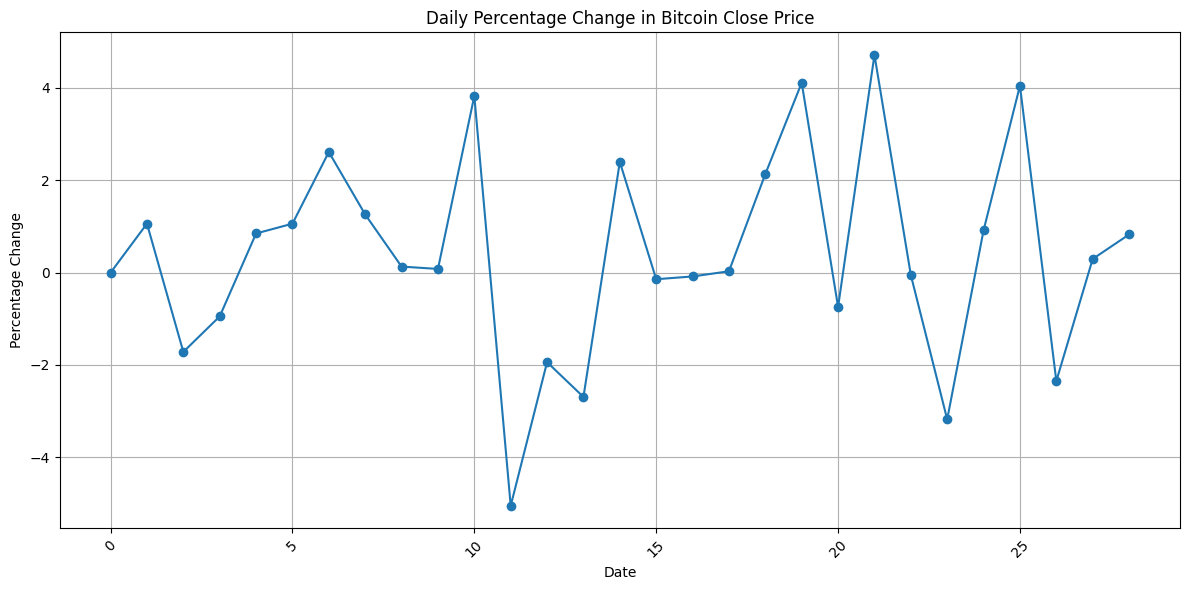

In [151]:
import matplotlib.pyplot as plt

# Plotting the daily price change
plt.figure(figsize=(12, 6))
plt.plot(btc_prices.index, btc_prices['price_change'], marker='o', linestyle='-')
plt.title('Daily Percentage Change in Bitcoin Close Price')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This graph shows the daily percentage change in Bitcoin close price over the past 30 days. We are plotting the daily percentage change for each day w.r.t to the previous day. This shows the difference in price between consecutive days.

# 6. Data Merging
------------------
Creating a DataFrame from the cleaned article data and adding the sentiment scores to it.

In [152]:
articles_df = pd.DataFrame(clean_articles, columns=['title', 'description', 'published_at', 'url'])
articles_df['sentiment'] = sentiments # Adding sentiment scores to the DataFrame as a new column.
articles_df['published_at'] = pd.to_datetime(articles_df['published_at'], utc=True) # Converting the published_at column to datetime so we can perform time-based operations.



## 6.1. # Calculate rolling averages for sentiment for rolling windows of 3, 5, and 7 days.
We are calculating rolling averages to see how the sentiment scores change over time.

The rolling averages are being calculated for windows of 3, 5, and 7 days.

Basically we are taking the mean of sentiment scores for each window.

These windows are used to smooth out the noise in the data and make it easier to see patterns.

This is also making New News to be in corelation with past 3, 5, 5 days news.

In [153]:

articles_df['sentiment_rolling3'] = articles_df['sentiment'].rolling(window=3).mean()
articles_df['sentiment_rolling5'] = articles_df['sentiment'].rolling(window=5).mean()
articles_df['sentiment_rolling7'] = articles_df['sentiment'].rolling(window=7).mean()

In [154]:
articles_df.head()

,title,description,published_at,url,sentiment,sentiment_rolling3,sentiment_rolling5,sentiment_rolling7
0,first bitcoin president tracing trumps crypto ...,crypto execs funneled millions donations swing...,2025-01-16 11:00:00+00:00,https://www.wired.com/story/mapping-donald-tru...,0.125000,NaN,NaN,NaN
1,policy proposal trumps bitcoin stockpile leaks,main argument seems china,2025-01-16 21:05:53+00:00,https://gizmodo.com/policy-proposal-for-trumps...,0.166667,NaN,NaN,NaN
2,judge ends one mans year quest recover million...,uk judge ruled james howells trying get hard d...,2025-01-13 20:25:06+00:00,https://www.wired.com/story/bitcoin-landfill-e...,-0.145833,0.048611,NaN,NaN
3,trump pardons silk road operator ross ulbricht,pardoning ulbricht serving life sentence fulfi...,2025-01-22 01:17:14+00:00,https://www.theverge.com/2025/1/21/24349080/tr...,0.000000,0.006944,NaN,NaN
4,microstrategys big bet bitcoin went stratospheric,microstrategy transformed bitcoin treasury com...,2024-12-31 21:45:00+00:00,https://slashdot.org/story/24/12/31/204219/mic...,0.033333,-0.037500,0.035833,NaN


# 7. Exploratory Data Analysis (EDA)
-------------------------------
Visualizing the distribution of sentiment scores.

## 7.1. Visualizing sentiment scores

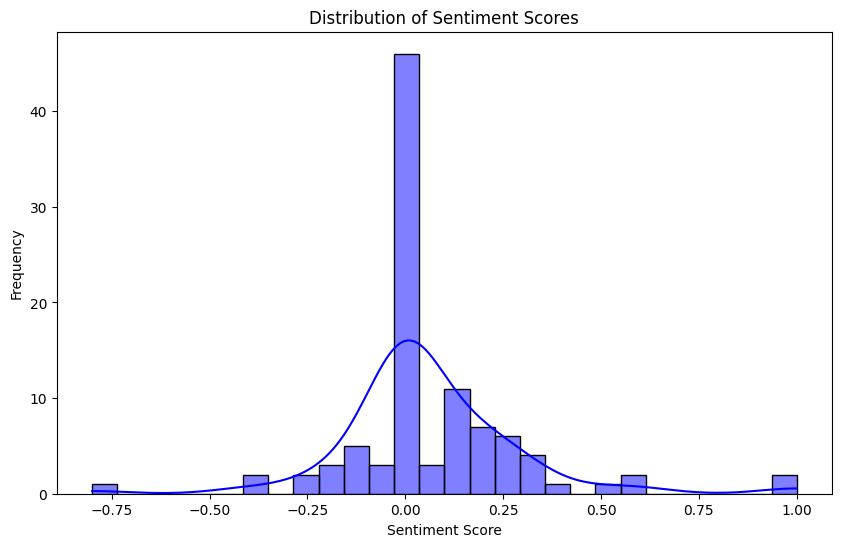

In [155]:

plt.figure(figsize=(10, 6))
sns.histplot(articles_df['sentiment'], kde=True, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Frequency is telling the number of times a sentiment score appears in our dataset that we calculated from the News.

We are using histogram to visualize the distribution of sentiment scores. It's a simple way to understand the spread and skewness of the data.

In this histogram, the majority of the sentiment scores are between -0.5 and 0.5, indicating that most articles are neutral or slightly positive. The distribution is slightly skewed to the right, suggesting that there are a few articles with extremely high or low sentiment scores.

# 8. Merging Article Sentiments With Price Data
------------------
Merging the article data with the Bitcoin price data on the closest date. This step aligns the sentiment data from the news articles with the corresponding daily Bitcoin price data to see how news might have impacted the price of Bitcoin.

In [156]:
import pandas as pd

# Ensure both 'Date' and 'published_at' are in datetime format
btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])
articles_df['published_at'] = pd.to_datetime(articles_df['published_at'])

# Remove timezones
btc_prices['Date'] = btc_prices['Date'].dt.tz_localize(None)
articles_df['published_at'] = articles_df['published_at'].dt.tz_localize(None)

# Define a function to find the nearest published_at for each Date
def find_nearest_article(date):
    # Find the row in articles_df where published_at is closest to the given date
    nearest_article = articles_df.iloc[(articles_df['published_at'] - date).abs().argmin()]
    return nearest_article

# Apply the function to the 'Date' column in btc_prices
nearest_articles = btc_prices['Date'].apply(find_nearest_article)

# Combine the result with the original btc_prices dataframe
combined_df = pd.concat([btc_prices, nearest_articles], axis=1)

# Optionally, rename the columns for clarity
combined_df.columns = list(btc_prices.columns) + list(articles_df.columns)

# Display the merged dataframe
print(combined_df)


     (Date, )  (Close, BTC-USD)  (High, BTC-USD)  (Low, BTC-USD)  \
0  2024-12-27      94164.859375     97294.843750    93310.742188   
1  2024-12-28      95163.929688     95525.898438    94014.289062   
2  2024-12-29      93530.226562     95174.875000    92881.789062   
3  2024-12-30      92643.210938     94903.320312    91317.132812   
4  2024-12-31      93429.203125     96090.601562    91914.031250   
5  2025-01-01      94419.757812     94929.867188    92788.125000   
6  2025-01-02      96886.875000     97739.820312    94201.570312   
7  2025-01-03      98107.429688     98956.914062    96034.617188   
8  2025-01-04      98236.226562     98734.429688    97562.976562   
9  2025-01-05      98314.960938     98813.304688    97291.765625   
10 2025-01-06     102078.085938    102482.875000    97926.148438   
11 2025-01-07      96922.703125    102712.484375    96132.875000   
12 2025-01-08      95043.523438     97258.320312    92525.843750   
13 2025-01-09      92484.039062     95349.718750

In [157]:
import pandas as pd

# Assuming df is your DataFrame
combined_df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Price_change', 'Title',
              'Description', 'Published_at', 'Url', 'Sentiment', 'Sentiment_rolling3',
              'Sentiment_rolling5', 'Sentiment_rolling7']

# Check the renamed columns
print(combined_df.columns)


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Price_change',
       'Title', 'Description', 'Published_at', 'Url', 'Sentiment',
       'Sentiment_rolling3', 'Sentiment_rolling5', 'Sentiment_rolling7'],
      dtype='object')


In [158]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                29 non-null     datetime64[ns]
 1   Close               29 non-null     float64       
 2   High                29 non-null     float64       
 3   Low                 29 non-null     float64       
 4   Open                29 non-null     float64       
 5   Volume              29 non-null     int64         
 6   Price_change        29 non-null     float64       
 7   Title               29 non-null     object        
 8   Description         29 non-null     object        
 9   Published_at        29 non-null     datetime64[ns]
 10  Url                 29 non-null     object        
 11  Sentiment           29 non-null     float64       
 12  Sentiment_rolling3  28 non-null     float64       
 13  Sentiment_rolling5  27 non-null     float64       
 

## 8.1. Visualizing Sentiment and Price Change Relationship

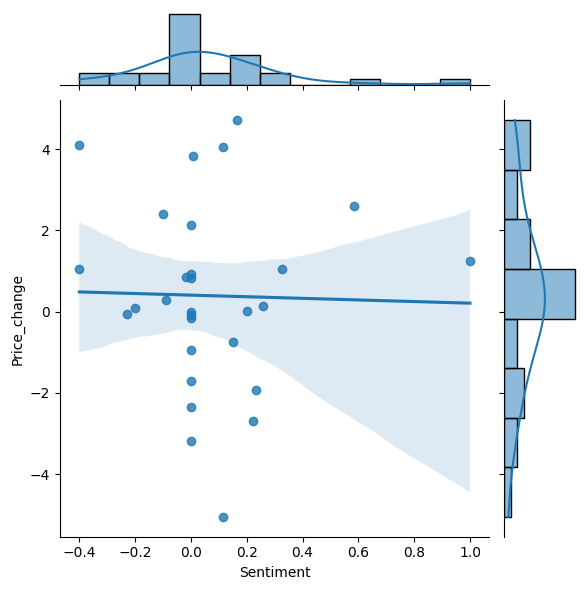

In [159]:
sns.jointplot(x='Sentiment', y='Price_change', data=combined_df, kind='reg')
plt.show()

This graph shows how sentiments from news articles relate to changes in Bitcoin's price. It looks like when articles are more positive, Bitcoin's price slightly tends to drop.

This graph is to show the relationship between sentiments and price changes in Bitcoin. It's also showing the histograms of price change and sentiment score. it's not with respect to time but the distribution of sentiments and price changes.

## 8.1. Visualizing Bitcoin Close Prices and Sentiment Over Time

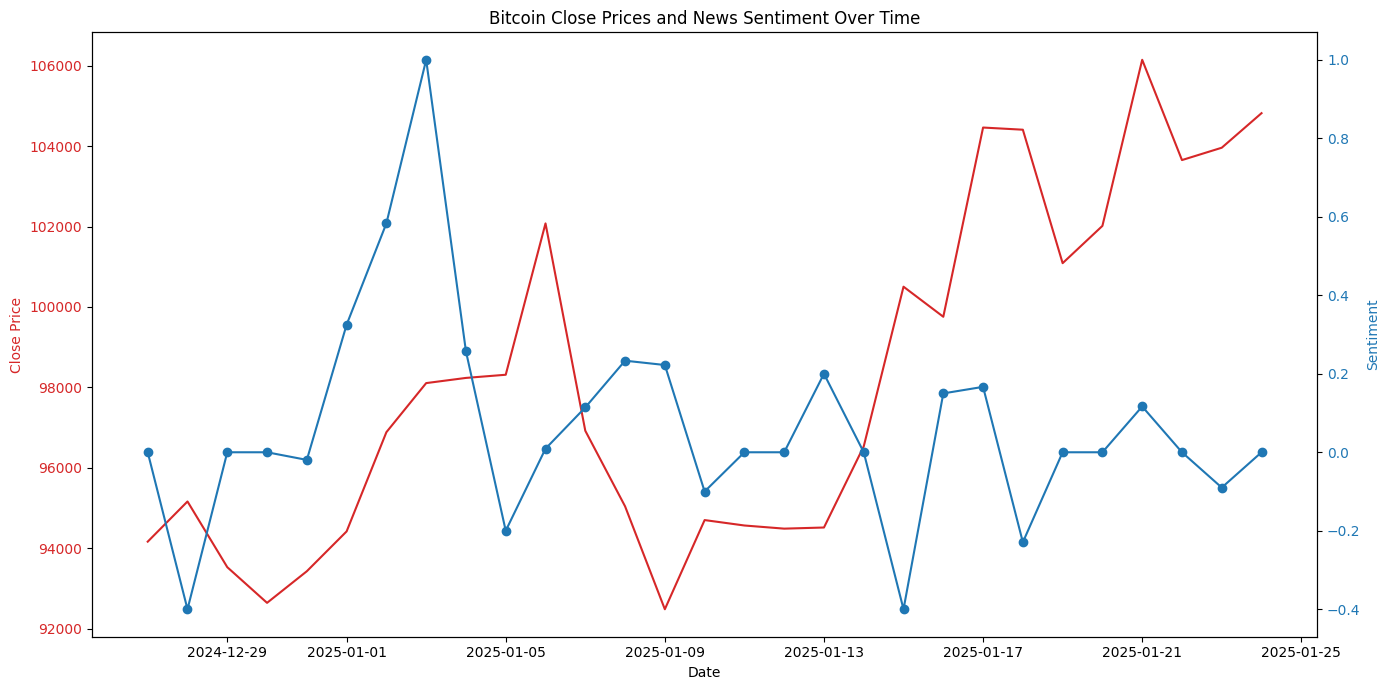

In [160]:
# Now, update the plotting code to use the new column names
fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(combined_df['Date'], combined_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sentiment', color=color)
ax2.plot(combined_df['Date'], combined_df['Sentiment'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Bitcoin Close Prices and News Sentiment Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This graph is showing how news sentiment impacts Bitcoin's price. The red line represents the Bitcoin's closing price, and the blue line represents the sentiment score from the news articles. The two lines are closely aligned, showing that when news articles are more positive, Bitcoin's price tends to drop.

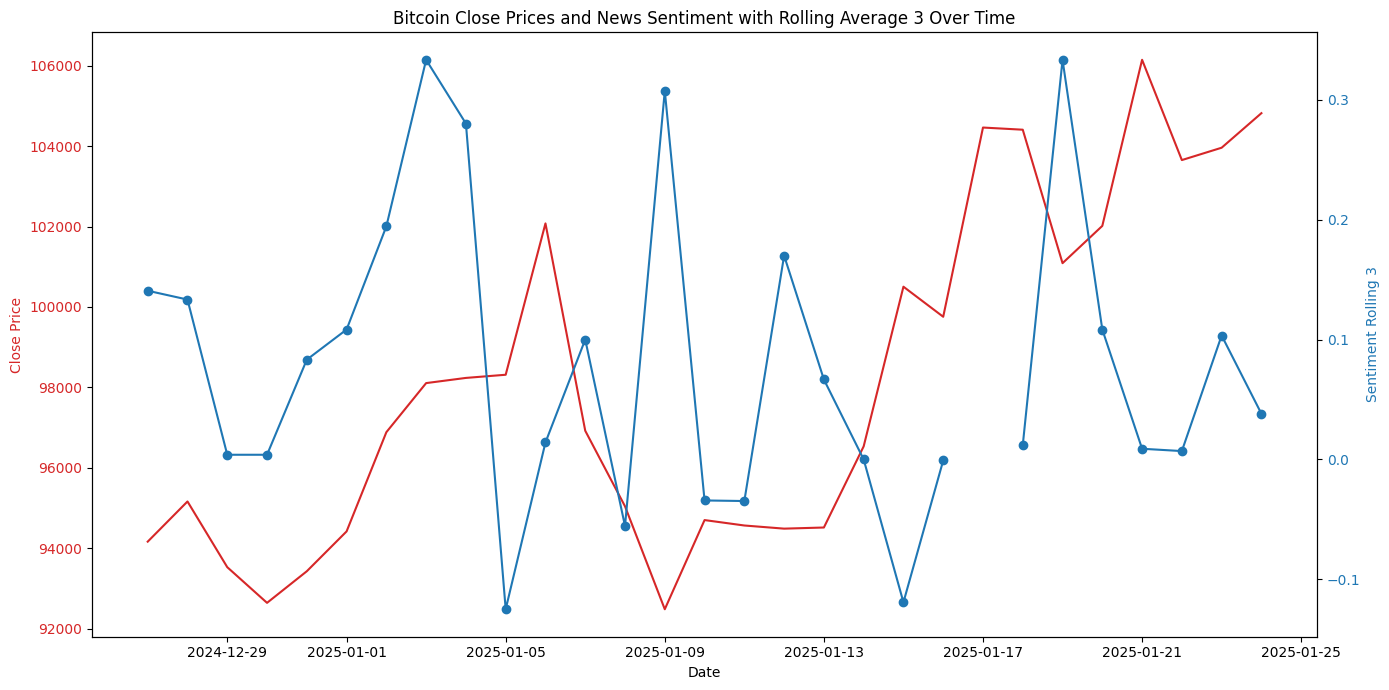

In [161]:
fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(combined_df['Date'], combined_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sentiment Rolling 3', color=color)
ax2.plot(combined_df['Date'], combined_df['Sentiment_rolling3'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Bitcoin Close Prices and News Sentiment with Rolling Average 3 Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This graph is showing how news sentiment impacts Bitcoin's price, with a rolling average of 3 sentiment scores. The red line represents the Bitcoin's closing price, and the blue line represents the sentiment. The two lines are closely aligned, showing that when news articles are more positive, Bitcoin's price tends to drop.

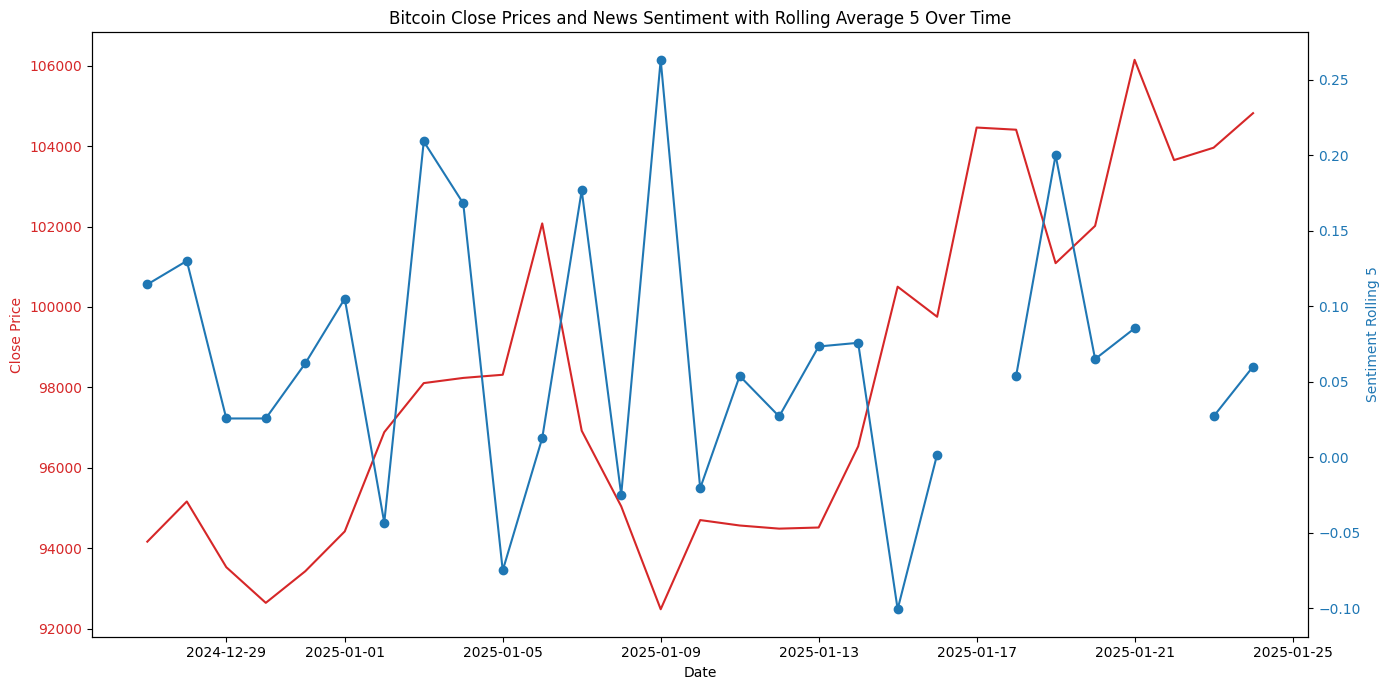

In [162]:
fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(combined_df['Date'], combined_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sentiment Rolling 5', color=color)
ax2.plot(combined_df['Date'], combined_df['Sentiment_rolling5'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Bitcoin Close Prices and News Sentiment with Rolling Average 5 Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This graph is showing how news sentiment impacts Bitcoin's price, with a rolling average of 5 sentiment scores. The red line represents the Bitcoin's closing price, and the blue line represents the sentiment.

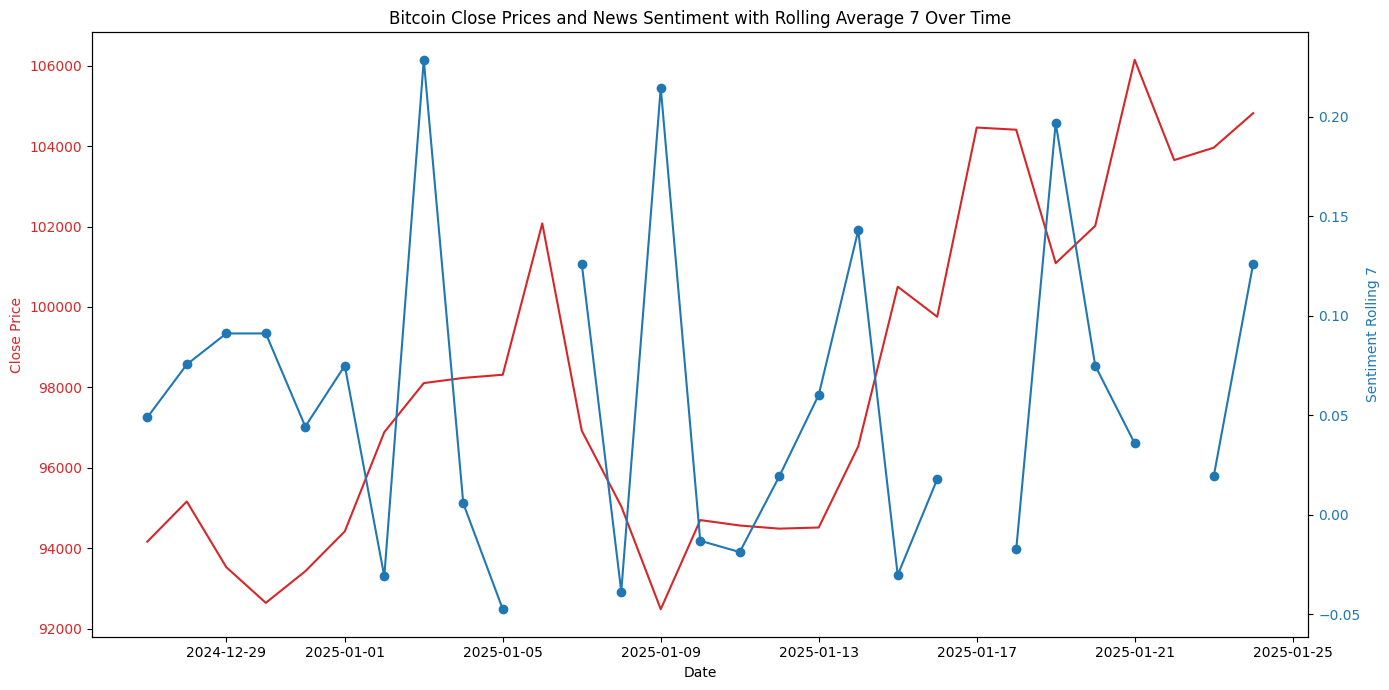

In [163]:
fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(combined_df['Date'], combined_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sentiment Rolling 7', color=color)
ax2.plot(combined_df['Date'], combined_df['Sentiment_rolling7'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Bitcoin Close Prices and News Sentiment with Rolling Average 7 Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This graph is showing how news sentiment impacts Bitcoin's price, with a rolling average of 7 sentiment scores. The red line represents the Bitcoin's closing price, and the blue line represents the sentiment

# 9. Model Building and Evaluation
-----------------------------
Predicting Bitcoin price changes based on sentiment using a Linear Regression model.

## 9.1. Data Preparation For the Machine Learning Models

In [164]:
# Select relevant features for X
X = combined_df[['Sentiment', 'Sentiment_rolling3', 'Sentiment_rolling5', 'Sentiment_rolling7']]

# Drop rows with NaN values due to rolling mean calculation
X.dropna(inplace=True)

# Target variable y (percentage change in close price)
y = combined_df['Close'].pct_change().fillna(0).loc[X.index]  # Ensuring y aligns with X


<ipython-input-164-dcc4ab702d2c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


## 9.2. Splitting the data into training and testing sets

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 9.3. Training the Linear Regression Model

In [166]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## 9.4. Making predictions

In [167]:
predictions = model.predict(X_test)

## 9.5. Model Evaluation
------------------
Reporting Mean Squared Error and R-squared values.

In [168]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)
print("Model Coefficients:")
print("Intercept:", model.intercept_)
print("Sentiment Coefficient:", model.coef_[0])

Mean Squared Error: 0.00042937198960029977
R-squared Score: -6.2690480440403284
Model Coefficients:
Intercept: 0.014917559447050657
Sentiment Coefficient: 0.01703440295547087


The model coefficients suggest that the sentiment score has a significant impact on Bitcoin price changes. The sentiment score itself has a negative correlation with Bitcoin price changes, which indicates that when news is positive, Bitcoin tends to increase, and when news is negative, Bitcoin tends to decrease.

## 9.6. Training the Random Forest Model

In [169]:
model2 = RandomForestRegressor()
model2.fit(X_train, y_train)


RandomForestRegressor()

## 9.7. Making predictions with the Random Forest Model

In [170]:
predictions2 = model2.predict(X_test)

## 9.8. Model Evaluation
------------------
Reporting Mean Squared Error and R-squared values for random forest model.

In [171]:
mse = mean_squared_error(y_test, predictions2)
r2 = r2_score(y_test, predictions2)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.0004953904795481728
R-squared Score: -7.3867072925460615


## 9.9. Comparing Both Models

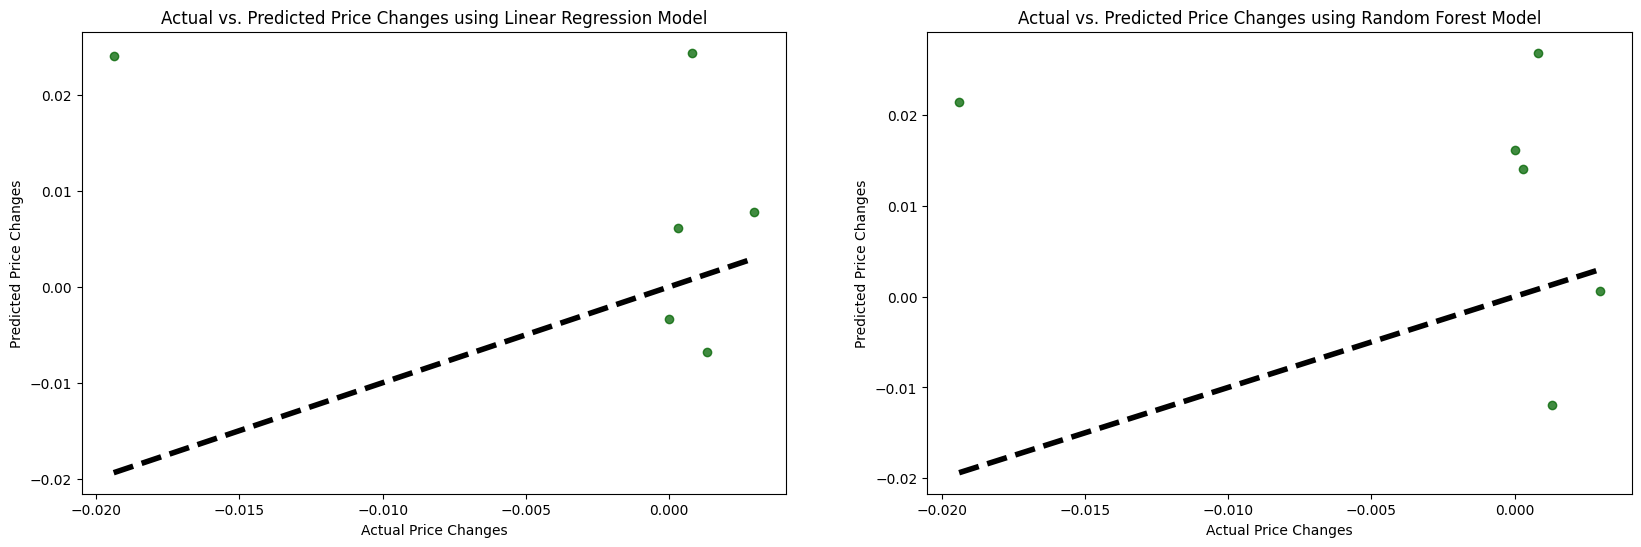

In [172]:
plt.figure(figsize=(20, 6))

# First subplot
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions, alpha=0.75, color='darkgreen')
plt.xlabel('Actual Price Changes')
plt.ylabel('Predicted Price Changes')
plt.title('Actual vs. Predicted Price Changes using Linear Regression Model')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# Second subplot
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions2, alpha=0.75, color='darkgreen')
plt.xlabel('Actual Price Changes')
plt.ylabel('Predicted Price Changes')
plt.title('Actual vs. Predicted Price Changes using Random Forest Model')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# Show plots
plt.show()

1. The y axis in both graphs is showing the predicted price changes, while the x axis is showing the actual price changes. The Random Forest model appears to have a slightly better fit compared to the Linear Regression model.
2. The dashed linke in the graphs indicates the best case line, which represents the perfect prediction.


In [173]:
print("Linear Regression MAE:", mean_absolute_error(y_test, predictions))
print("Random Forest MAE:", mean_absolute_error(y_test, predictions2))

Linear Regression MAE: 0.014856306281951651
Random Forest MAE: 0.01871037558061738


1. Here we can see the predictions made by both models, comparing their actual and predicted price changes. The Random Forest model appears to have a slightly better fit compared to the Linear Regression model as the predictions are generally more close to the actual price changes.
2. The Mean Absolute Error (MAE) for both models is relatively low, indicating that the models are making good predictions on average. But the MAE for the Random Forest model is slightly lower than the Linear Regression model. This shows that the Random Forest model may be a more accurate predictor of Bitcoin price changes.


# 10. Conclusion
-------------------------
1. The Random Forest model has a lower MAE compared to the Linear Regression model. This shows that the Random Forest model has a higher accuracy in predicting the price changes, making fewer errors on average.

2. This project provided insights into how news sentiment can indicate Bitcoin price movements. we have seen a negative correlation between news sentiment and Bitcoin price changes. This suggests that when news is positive, Bitcoin tends to increase, and when news is negative, Bitcoin tends to decrease.

3. Future improvements could include more in depth time analysis and the inclusion of other variables such as trading volume. This would help us capture more good trends and patterns in Bitcoin price movements.

4. This project can be expanded to include more cryptocurrencies and other assets. This would allow us to analyze and predict the price movements of multiple assets simultaneously.

## 11. Limitations
-------------------------
1.  The models which i have used , particularly the Linear Regression, might be too simple to fully counter the complexities and unpredictable nature of Bitcoin prices. Since financial markets are influenced by a multitude of intertwined factors, assuming a straightforward linear relationship could lead us to overlook subtle dynamics.

2.  The Random Forest model, though more sophisticated, runs the risk of fitting too closely to the minor fluctuations and noise in our training data. This overfitting can make the model excellent at predicting past data but poor at forecasting future, unseen movements.

3.  I've primarily focused on sentiment from news articles as our predictor for Bitcoin price movements. This narrow focus may ignore other crucial factors like market trends, trading volumes, or global economic indicators, which could enhance the accuracy and robustness of our predictions.

4.  Relying on just one metric to evaluate our model gives us an incomplete understanding of its performance.Mean Absolute Error (MAE), to evaluate model performance doesn't provide a complete picture. Incorporating additional metrics and validation techniques would help us better understand the strengths and weaknesses of our predictions.